Proof of concept convolutional neural network trained to predict the nonlinear subthreshold membrane voltage dynamics of a biological neuron modeled using the Hodkin and Huxley (J Physiol. 1952 Aug 28; 117(4): 500–544.
doi: https://doi.org/10.1113/jphysiol.1952.sp004764) formalism, to noisy (synaptic) input currents. 

To generate training/validation data file(s), run the notebook HodkinHuxleyDataGeneration.ipynb first, or install git LFS (https://git-lfs.github.com) and pull the precomputed file(s). 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import HDF5Matrix

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11064940442587762953
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16261294476655245135
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1481872591589062408
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11269973607
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17602677049058330112
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [4]:
np.random.seed(1234)

In [5]:
# number of validation datas
n_val = 500

# load training/validation data
X = HDF5Matrix('HodkinHuxleySubthresholdData.h5', 'X')
Y = HDF5Matrix('HodkinHuxleySubthresholdData.h5', 'Y')

# test data
X_test = HDF5Matrix('HodkinHuxleySubthresholdData.h5', 'X_test')
Y_test = HDF5Matrix('HodkinHuxleySubthresholdData.h5', 'Y_test')

/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/utils/io_utils.py:70: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


In [6]:
X.shape, Y.shape

((10000, 1000, 1), (10000, 1000, 1))

In [7]:
def generate_model(input_shape, lr=0.001, layer_sizes=[2, 6, 16], 
                  kernel_sizes=[11, 5, 1]):
    keras.backend.clear_session()

    # Define model
    model = keras.models.Sequential()
    
    # input layer
    model.add(keras.layers.InputLayer(input_shape))

    # convolutional layers and activation
    for ls, ks in zip(layer_sizes, kernel_sizes):
        model.add(keras.layers.Conv1D(ls, 
                                      kernel_size=ks, 
                                      padding='same',
                                      kernel_regularizer=l2(),
                                      bias_regularizer=l2(),
                                      activation='relu'))

    # dense output layer
    model.add(keras.layers.TimeDistributed(
        keras.layers.Dense(1, activation='linear')))

    # optimizer
    opt = keras.optimizers.Adam(lr=lr)

    # compile model
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])

    return model

In [8]:
model = generate_model(input_shape=(None, 1))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 2)           24        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 6)           66        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          112       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           17        
Total params: 219
Trainable params: 219
Non-trainable params: 0
_________________________________________________________________


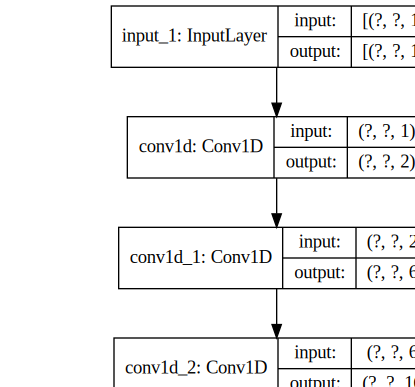

In [10]:
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

#plot_model(model, to_file='model.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
history = model.fit(X[:-n_val], 
                    Y[:-n_val], batch_size=100, epochs=100, 
                    validation_data=(X[-n_val:], Y[-n_val:]))

Train on 9500 samples, validate on 500 samples
Epoch 1/100
9500/9500 [==============================] - 3s 339us/sample - loss: 2807.2583 - mse: 2807.1162 - val_loss: 1578.9179 - val_mse: 1578.7679
Epoch 2/100
9500/9500 [==============================] - 1s 84us/sample - loss: 1369.2984 - mse: 1369.1410 - val_loss: 1147.4120 - val_mse: 1147.2389
Epoch 3/100
9500/9500 [==============================] - 1s 83us/sample - loss: 1008.0685 - mse: 1007.8710 - val_loss: 870.9234 - val_mse: 870.7014
Epoch 4/100
9500/9500 [==============================] - 1s 82us/sample - loss: 791.8509 - mse: 791.6081 - val_loss: 717.2214 - val_mse: 716.9594
Epoch 5/100
9500/9500 [==============================] - 1s 82us/sample - loss: 672.7294 - mse: 672.4511 - val_loss: 628.4067 - val_mse: 628.1124
Epoch 6/100
9500/9500 [==============================] - 1s 84us/sample - loss: 597.8814 - mse: 597.5727 - val_loss: 567.1997 - val_mse: 566.8769
Epoch 7/100
9500/9500 [==============================] - 1s 83us/s

Text(0.5, 1.0, 'training/validation loss')

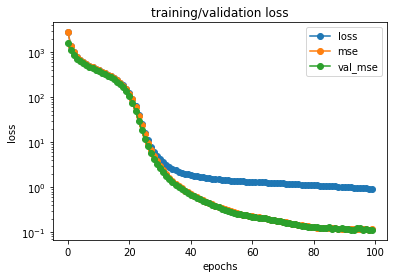

In [12]:
plt.figure()
plt.semilogy(history.history['loss'], '-o', label='loss')
plt.semilogy(history.history['mse'], '-o', label='mse')
plt.semilogy(history.history['val_mse'], '-o', label='val_mse')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training/validation loss')

Text(0.5, 0, '$t$ (ms)')

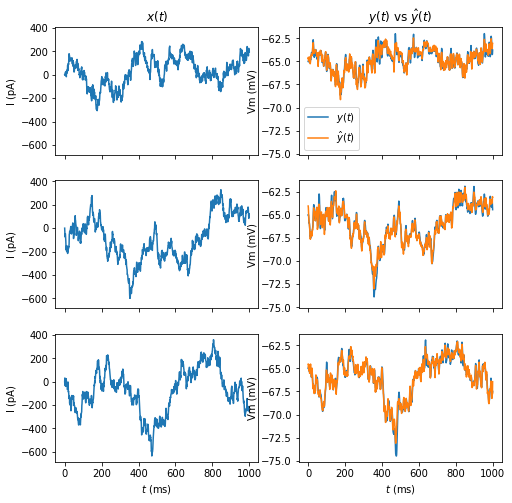

In [13]:
# visualize predictions on some samples from the training/validation set
X_val = X[-n_val:]
Y_val = Y[-n_val:]

Y_pred = model.predict(X_val)

# compare prediction to ground truth
fig, axes = plt.subplots(3, 2, figsize=(8, 8), 
                         sharex=True, sharey='col')
for i in range(3):
    axes[i, 0].plot(X_val[i], label='$x(t)$')
    axes[i, 1].plot(Y_val[i], label='$y(t)$')
    axes[i, 1].plot(Y_pred[i], label='$\hat{y}(t)$')
    if i == 0:
        axes[i, 1].legend()
        axes[i, 0].set_title('$x(t)$')
        axes[i, 1].set_title('$y(t)$ vs $\hat{y}(t)$')
    axes[i, 0].set_ylabel('I (pA)')
    axes[i, 1].set_ylabel('Vm (mV)')
axes[i, 0].set_xlabel('$t$ (ms)')
axes[i, 1].set_xlabel('$t$ (ms)')

Text(0.5, 0, '$t$ (ms)')

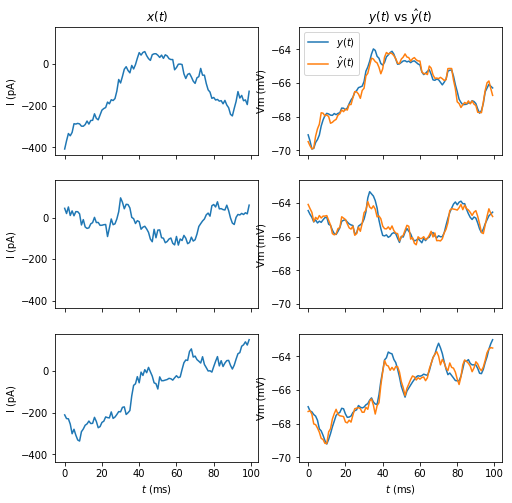

In [14]:
# test with time series longer than training set time series
Y_pred = model.predict(X_test)

# compare prediction to ground truth
fig, axes = plt.subplots(3, 2, figsize=(8, 8), 
                         sharex=True, sharey='col')
for i in range(3):
    axes[i, 0].plot(X_test[i][2900:3000], label='$x(t)$')
    axes[i, 1].plot(Y_test[i][2900:3000], label='$y(t)$')
    axes[i, 1].plot(Y_pred[i][2900:3000], label='$\hat{y}(t)$')
    if i == 0:
        axes[i, 1].legend()
        axes[i, 0].set_title('$x(t)$')
        axes[i, 1].set_title('$y(t)$ vs $\hat{y}(t)$')
    axes[i, 0].set_ylabel('I (pA)')
    axes[i, 1].set_ylabel('Vm (mV)')
axes[i, 0].set_xlabel('$t$ (ms)')
axes[i, 1].set_xlabel('$t$ (ms)')